# Project - Boston - Airbnb review

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#TP">Inspiration</a></li>
<li><a href="#AS">Analysis</a></li>
</ul>

<a id='intro'></a>
## Introduction

> Since 2008, guests and hosts have used Airbnb to travel in a more unique, personalized way. As part of the Airbnb Inside initiative, this dataset describes the listing activity of homestays in Boston, MA.
- The following Airbnb activity is included in this Boston dataset: 
    * Listings, including full descriptions and average review score 
    * Reviews, including unique id for each reviewer and detailed comments 
    * Calendar, including listing id and the price and availability for that day
- Information is extracted from the source [here](https://www.kaggle.com/airbnb/boston)

<a id='TP'></a>

## Inspiration & Workflow

> With the datasets thats available, we can actually help Airbnb answer some interesting questions. We will use the [CRISP-DM](https://en.wikipedia.org/wiki/Cross-industry_standard_process_for_data_mining) framework with minor tweaks to complete this workflow. The coding standard will have PEP8 framework incorporated with in [them](https://www.python.org/dev/peps/pep-0008/)

<a id='AS'></a>
## CRISP-DM Framework

<ul>
<li><a href="#A">Business Understanding</a></li>
<li><a href="#B">Data understading</a></li>
<li><a href="#C">Data preperation</a></li>
<li><a href="#D">Modeling</a></li>
<li><a href="#E">Fine-tuning</a></li>
<li><a href="#F">Conclusion</a></li>
</ul>

<a id='A'></a>

## Business Understanding

As I mentioned in the introduction, Boston Airbnb dataset has the information on the -
1. Calendar - This gives information whether the property is available for a certain timeline or not; If it is available the cost involved in blocking the property
2. Listings - This dataset gives the understanding of the property type, owner's credibility, property quality, occupancy etc
3. Reviews - This dataset gives an understanding of the reviews that users gave over time - We can do a sentiment analysis if we really want to mine this information

<a id='B'></a>

## Data Understanding

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

#Pre Processing Libraries
from sklearn.preprocessing import Imputer as IP
from sklearn.preprocessing import StandardScaler as SS
from sklearn.cross_validation import train_test_split

#Different models input statements
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import svm

#To print the best parameters
from pprint import pprint

#Model tuning libraries
from sklearn import grid_search
from sklearn.model_selection import GridSearchCV

#Model evaluation metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from time import time


%matplotlib inline

pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [3]:
calendar = pd.read_csv('./Boston/calendar.csv')
listings = pd.read_csv('./Boston/listings.csv')
reviews = pd.read_csv('./Boston/reviews.csv')

#### Dataset preview function - Only for Calendar & Reviews dataset

In [4]:
def dataset_desc(df):
    
    print("The contents of the dataset are")
    print(df.info())
    print("\n Time is as per follows")
    print(df.date.max())
    print(df.date.min())

In [5]:
dataset_desc(calendar)

The contents of the dataset are
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308890 entries, 0 to 1308889
Data columns (total 4 columns):
listing_id    1308890 non-null int64
date          1308890 non-null object
available     1308890 non-null object
price         643037 non-null object
dtypes: int64(1), object(3)
memory usage: 39.9+ MB
None

 Time is as per follows
2017-09-05
2016-09-06


> Looks like the dataset has listings by date for the last 1 year ending 05th Sep 2017. While the Listings are availble for 50% of the times

In [6]:
dataset_desc(reviews)

The contents of the dataset are
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68275 entries, 0 to 68274
Data columns (total 6 columns):
listing_id       68275 non-null int64
id               68275 non-null int64
date             68275 non-null object
reviewer_id      68275 non-null int64
reviewer_name    68275 non-null object
comments         68223 non-null object
dtypes: int64(3), object(3)
memory usage: 3.1+ MB
None

 Time is as per follows
2016-09-06
2009-03-21


> Reviews dataset is availabe for a longer time line from 2009 to 2016. As there is no overlap between Calendar & Reviews dataset we may need to rely on Listings dataset only for the rest of our analysis

In [7]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",NaN,"The bus stop is 2 blocks away, and frequent. B...","You will have access to 2 bedrooms, a living r...",NaN,Clean up and treat the home the way you'd like...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,31303940,https://www.airbnb.com/users/show/31303940,Virginia,2015-04-15,"Boston, Massachusetts, United States",We are country and city connecting in our deck...,NaN,NaN,NaN,f,https://a2.muscache.com/im/pictures/5936fef0-b...,https://a2.muscache.com/im/pictures/5936fef0-b...,Roslindale,1,1,"['email', 'phone', 'facebook', 'reviews']",t,f,"Birch Street, Boston, MA 02131, United States",Roslindale,Roslindale,NaN,Boston,MA,02131,Boston,"Boston, MA",US,United States,42.282619,-71.133068,t,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",NaN,$250.00,NaN,NaN,NaN,$35.00,1,$0.00,2,1125,2 weeks ago,NaN,0,0,0,0,2016-09-06,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...","If you don't have a US cell phone, you can tex...",Plenty of safe street parking. Bus stops a few...,Apt has one more bedroom (which I use) and lar...,"If I am at home, I am likely working in my hom...",Pet friendly but please confirm with me if the...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,2572247,https://www.airbnb.com/users/show/2572247,Andrea,2012-06-07,"Boston, Massachusetts, United States",I live in Boston and I like to travel and have...,within an hour,100%,100%,f,https://a2.muscache.com/im/users/2572247/profi...,https://a2.muscache.com/im/users/2572247/profi...,Roslindale,1,1,"['email', 'phone', 'facebook', 'linkedin', 'am...",t,t,"Pinehurst Street, Boston, MA 02131, United Sta

In [8]:
listings.shape

(3585, 95)

In [9]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
id                                  3585 non-null int64
listing_url                         3585 non-null object
scrape_id                           3585 non-null int64
last_scraped                        3585 non-null object
name                                3585 non-null object
summary                             3442 non-null object
space                               2528 non-null object
description                         3585 non-null object
experiences_offered                 3585 non-null object
neighborhood_overview               2170 non-null object
notes                               1610 non-null object
transit                             2295 non-null object
access                              2096 non-null object
interaction                         2031 non-null object
house_rules                         2393 non-null object
thumbnail_url                       2986

The listing data has a rich source of information and context. It has details on the quality of the listing offered, host's credibility, reviews related to scoring etc. We can actually use this data to understand the pricing characteristics

> Before going into data preperation, I am listing down the list of changes that we may need to bring to make this dataset usable
    1. Calendar - 
        a. Create a date column only containing the month-year of the listing
        b. Create a date column only containing the day with in the week
        c. Price is in  object. Need to convert into number
    2. Listings -
        a. Amenities - At present, Amenities are binned into a single column. Create the additional columns listing all the aminities available
        b. We will delete few unnecessary columns and only keep relevant fields - I will substantiate it with the reasoning
        c. Price is in object. Need to convert into number
        d. Check for outlier patterns in price and delete them accordingly
        e. Convert T or F values in a column to 1 or 0 respectively

<a id='C'></a>

## Data Preperation

In [10]:
#Necessary adjustments for Calendar 
date_columns = ['date']
for c in date_columns:
    calendar[c] = pd.to_datetime(calendar[c])
    calendar[c] = calendar[c].dt.date
    c_temp=c+'weekday'
    # 0 - Sunday & 6 - Saturday
    calendar[c_temp] = calendar[c].apply(lambda x: dt.datetime.strftime(x, '%w'))
    calendar[c_temp] = pd.to_numeric(calendar[c_temp])
    c_month = c+'month'
    calendar[c_month] = calendar[c].apply(lambda x: dt.datetime.strftime(x, '%m-%Y'))
    calendar[c_month] = pd.to_datetime(calendar[c_month])
        
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308890 entries, 0 to 1308889
Data columns (total 6 columns):
listing_id     1308890 non-null int64
date           1308890 non-null object
available      1308890 non-null object
price          643037 non-null object
dateweekday    1308890 non-null int64
datemonth      1308890 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 59.9+ MB


In [11]:
#Change price to number

calendar['price'] = calendar['price'].replace(np.nan, 0)



In [12]:
calendar['price'] = calendar['price'].replace('[\$,]', '', regex=True).astype(float)


#### Listings dataset

#### Start preparing a features dataset that we will be using for the modelling puposes

In [13]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
id                                  3585 non-null int64
listing_url                         3585 non-null object
scrape_id                           3585 non-null int64
last_scraped                        3585 non-null object
name                                3585 non-null object
summary                             3442 non-null object
space                               2528 non-null object
description                         3585 non-null object
experiences_offered                 3585 non-null object
neighborhood_overview               2170 non-null object
notes                               1610 non-null object
transit                             2295 non-null object
access                              2096 non-null object
interaction                         2031 non-null object
house_rules                         2393 non-null object
thumbnail_url                       2986

After examining all the columns and their properties, I am considering following characteristics to model the pricing 
1. Host characterisitcs like response time, response rate, acceptance rate, superhost etc,
2. Neighbourhood & Room characteristics
3. Policy of the hosts and review scores attained
4. Amenities



In [14]:
features = listings[['host_response_time','host_response_rate','host_acceptance_rate',
                     'host_is_superhost','neighbourhood_cleansed','room_type',
                     'accommodates','minimum_nights','cancellation_policy','require_guest_profile_picture',
                     'require_guest_phone_verification','amenities','price','bedrooms','bathrooms']]

In [15]:
features.head()

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,neighbourhood_cleansed,room_type,accommodates,minimum_nights,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,amenities,price,bedrooms,bathrooms
0,NaN,NaN,NaN,f,Roslindale,Entire home/apt,4,2,moderate,f,f,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",$250.00,2.0,1.5
1,within an hour,100%,100%,f,Roslindale,Private room,2,2,moderate,f,f,"{TV,Internet,""Wireless Internet"",""Air Conditio...",$65.00,1.0,1.0
2,within a few hours,100%,88%,t,Roslindale,Private room,2,3,moderate,t,f,"{TV,""Cable TV"",""Wireless Internet"",""Air Condit...",$65.00,1.0,1.0
3,within a few hours,100%,50%,f,Roslindale,Private room,4,1,moderate,f,f,"{TV,Internet,""Wireless Internet"",""Air Conditio...",$75.00,1.0,1.0
4,within an hour,100%,100%,t,Roslindale,Private room,2,2,flexible,f,f,"{Internet,""Wireless Internet"",""Air Conditionin...",$79.00,1.0,1.5


In [16]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 15 columns):
host_response_time                  3114 non-null object
host_response_rate                  3114 non-null object
host_acceptance_rate                3114 non-null object
host_is_superhost                   3585 non-null object
neighbourhood_cleansed              3585 non-null object
room_type                           3585 non-null object
accommodates                        3585 non-null int64
minimum_nights                      3585 non-null int64
cancellation_policy                 3585 non-null object
require_guest_profile_picture       3585 non-null object
require_guest_phone_verification    3585 non-null object
amenities                           3585 non-null object
price                               3585 non-null object
bedrooms                            3575 non-null float64
bathrooms                           3571 non-null float64
dtypes: float64(2), int64(2), object(1

#### Replace NaN with zeroes in the entire dataset. The problem with null values is minimal. Hence we can try this step

In [17]:
features = features.replace(np.nan, 0)

In [18]:
features.head()

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,neighbourhood_cleansed,room_type,accommodates,minimum_nights,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,amenities,price,bedrooms,bathrooms
0,0,0,0,f,Roslindale,Entire home/apt,4,2,moderate,f,f,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",$250.00,2.0,1.5
1,within an hour,100%,100%,f,Roslindale,Private room,2,2,moderate,f,f,"{TV,Internet,""Wireless Internet"",""Air Conditio...",$65.00,1.0,1.0
2,within a few hours,100%,88%,t,Roslindale,Private room,2,3,moderate,t,f,"{TV,""Cable TV"",""Wireless Internet"",""Air Condit...",$65.00,1.0,1.0
3,within a few hours,100%,50%,f,Roslindale,Private room,4,1,moderate,f,f,"{TV,Internet,""Wireless Internet"",""Air Conditio...",$75.00,1.0,1.0
4,within an hour,100%,100%,t,Roslindale,Private room,2,2,flexible,f,f,"{Internet,""Wireless Internet"",""Air Conditionin...",$79.00,1.0,1.5


#### Convert categorical columns through one hot encoding

In [19]:
# Host_Response_Time

features.groupby('host_response_time').count()

,host_response_rate,host_acceptance_rate,host_is_superhost,neighbourhood_cleansed,room_type,accommodates,minimum_nights,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,amenities,price,bedrooms,bathrooms
host_response_time,,,,,,,,,,,,,,
0,471,471,471,471,471,471,471,471,471,471,471,471,471,471
a few days or more,43,43,43,43,43,43,43,43,43,43,43,43,43,43
within a day,469,469,469,469,469,469,469,469,469,469,469,469,469,469
within a few hours,1218,1218,1218,1218,1218,1218,1218,1218,1218,1218,1218,1218,1218,1218
within an hour,1384,1384,1384,1384,1384,1384,1384,1384,1384,1384,1384,1384,1384,1384


In [20]:
host_response_time = features.host_response_time.str.get_dummies(sep = ",")

In [21]:
host_response_time.rename(columns = {'0':'Not Available'},inplace=True)

#### Convert Host response variable from % to numeric

In [22]:
features['host_response_rate'] = listings['host_response_rate'].replace('[%]', '', regex=True).astype(float)

In [23]:
features['host_acceptance_rate'] = listings['host_acceptance_rate'].replace('[%]', '', regex=True).astype(float)

#### Convert columns with t, f to numeric

In [24]:

cols = ['host_is_superhost','require_guest_profile_picture','require_guest_phone_verification']

for c in cols:
    new_values = {'f': 0, 't': 1}
    features = features.replace({c:new_values})


In [25]:
features.head()

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,neighbourhood_cleansed,room_type,accommodates,minimum_nights,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,amenities,price,bedrooms,bathrooms
0,0,NaN,NaN,0,Roslindale,Entire home/apt,4,2,moderate,0,0,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",$250.00,2.0,1.5
1,within an hour,100.0,100.0,0,Roslindale,Private room,2,2,moderate,0,0,"{TV,Internet,""Wireless Internet"",""Air Conditio...",$65.00,1.0,1.0
2,within a few hours,100.0,88.0,1,Roslindale,Private room,2,3,moderate,1,0,"{TV,""Cable TV"",""Wireless Internet"",""Air Condit...",$65.00,1.0,1.0
3,within a few hours,100.0,50.0,0,Roslindale,Private room,4,1,moderate,0,0,"{TV,Internet,""Wireless Internet"",""Air Conditio...",$75.00,1.0,1.0
4,within an hour,100.0,100.0,1,Roslindale,Private room,2,2,flexible,0,0,"{Internet,""Wireless Internet"",""Air Conditionin...",$79.00,1.0,1.5


In [26]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 15 columns):
host_response_time                  3585 non-null object
host_response_rate                  3114 non-null float64
host_acceptance_rate                3114 non-null float64
host_is_superhost                   3585 non-null int64
neighbourhood_cleansed              3585 non-null object
room_type                           3585 non-null object
accommodates                        3585 non-null int64
minimum_nights                      3585 non-null int64
cancellation_policy                 3585 non-null object
require_guest_profile_picture       3585 non-null int64
require_guest_phone_verification    3585 non-null int64
amenities                           3585 non-null object
price                               3585 non-null object
bedrooms                            3585 non-null float64
bathrooms                           3585 non-null float64
dtypes: float64(4), int64(5), object(6)

#### Convert columns with categorical values through one hot encoding

In [27]:
features.groupby('room_type').count()

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,neighbourhood_cleansed,accommodates,minimum_nights,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,amenities,price,bedrooms,bathrooms
room_type,,,,,,,,,,,,,,
Entire home/apt,2127,1870,1870,2127,2127,2127,2127,2127,2127,2127,2127,2127,2127,2127
Private room,1378,1176,1176,1378,1378,1378,1378,1378,1378,1378,1378,1378,1378,1378
Shared room,80,68,68,80,80,80,80,80,80,80,80,80,80,80


#### Drop the Shared Room listings as only 80 samples are there and we make not be able to make enough inference

In [28]:
features = features[features['room_type']!="Shared room"]

In [29]:
room_type = features.room_type.str.get_dummies(sep=",")

In [30]:
cancellation_policy = features.cancellation_policy.str.get_dummies(sep=",")

In [31]:
cancellation_policy.sum()

flexible            958
moderate            905
strict             1557
super_strict_30      85
dtype: int64

#### Super strict 30 is an invitation only program. Lets see the impact that this program has in overall model activity


#### Clean up amenities column

In [32]:
features['amenities'] = features.amenities.str.replace("[{}]", "") 

amenity_dum = features.amenities.str.get_dummies(sep = ",")

amenity_dum.head()

,"""24-Hour Check-in""","""Air Conditioning""","""Buzzer/Wireless Intercom""","""Cable TV""","""Carbon Monoxide Detector""","""Elevator in Building""","""Family/Kid Friendly""","""Fire Extinguisher""","""First Aid Kit""","""Free Parking on Premises""","""Free Parking on Street""","""Hair Dryer""","""Hot Tub""","""Indoor Fireplace""","""Laptop Friendly Workspace""","""Lock on Bedroom Door""","""Other pet(s)""","""Paid Parking Off Premises""","""Pets Allowed""","""Pets live on this property""","""Safety Card""","""Smoke Detector""","""Smoking Allowed""","""Suitable for Events""","""Washer / Dryer""","""Wheelchair Accessible""","""Wireless Internet""","""translation missing: en.hosting_amenity_49""","""translation missing: en.hosting_amenity_50""",Breakfast,Cat(s),Dog(s),Doorman,Dryer,Essentials,Gym,Hangers,Heating,Internet,Iron,Kitchen,Pool,Shampoo,TV,Washer
0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,1,0,0,1,0,1,1,1
1,0,1,0,0,1,0,1,1,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1,1,0,1,1,1,1,1,0,1,1,1
2,0,1,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,1,1,1
3,0,1,0,0,1,0,0,1,1,1,0,1,0,1,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1
4,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,1,1,1,1,0,1,0,0


In [33]:
# Delete few columns where the values are scanty

amenities_scope = pd.DataFrame(amenity_dum.sum())

amenities_scope.reset_index(inplace=True)



In [34]:
amenities_scope['Listings_proportion'] = amenities_scope[0]/features.shape[0]

In [35]:
amenities_scope.sort_values(0,ascending=True)

,index,0,Listings_proportion
24,"""Washer / Dryer""",2,0.000571
17,"""Paid Parking Off Premises""",4,0.001141
10,"""Free Parking on Street""",8,0.002282
16,"""Other pet(s)""",16,0.004565
22,"""Smoking Allowed""",87,0.024822
23,"""Suitable for Events""",130,0.037090
25,"""Wheelchair Accessible""",145,0.041369
41,Pool,158,0.045078
12,"""Hot Tub""",161,0.045934
30,Cat(s),175,0.049929


In [36]:
#### Eliminate columns whose values are less than 100

list(amenities_scope[amenities_scope[0]<=100]['index'])

['"Free Parking on Street"',
 '"Other pet(s)"',
 '"Paid Parking Off Premises"',
 '"Smoking Allowed"',
 '"Washer / Dryer"']

#### Concatenate the columns to form a single dataset

In [37]:
features_set = pd.concat([features, amenity_dum, cancellation_policy, room_type, host_response_time],axis=1)

In [38]:
features_set.head()

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,neighbourhood_cleansed,room_type,accommodates,minimum_nights,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,amenities,price,bedrooms,bathrooms,"""24-Hour Check-in""","""Air Conditioning""","""Buzzer/Wireless Intercom""","""Cable TV""","""Carbon Monoxide Detector""","""Elevator in Building""","""Family/Kid Friendly""","""Fire Extinguisher""","""First Aid Kit""","""Free Parking on Premises""","""Free Parking on Street""","""Hair Dryer""","""Hot Tub""","""Indoor Fireplace""","""Laptop Friendly Workspace""","""Lock on Bedroom Door""","""Other pet(s)""","""Paid Parking Off Premises""","""Pets Allowed""","""Pets live on this property""","""Safety Card""","""Smoke Detector""","""Smoking Allowed""","""Suitable for Events""","""Washer / Dryer""","""Wheelchair Accessible""","""Wireless Internet""","""translation missing: en.hosting_amenity_49""","""translation missing: en.hosting_amenity_50""",Breakfast,Cat(s),Dog(s),Doorman,Dryer,Essentials,Gym,Hangers,Heating,Internet,Iron,Kitchen,Pool,Shampoo,TV,Washer,flexible,moderate,strict,super_strict_30,Entire home/apt,Private room,Not Available,a few days or more,within a day,within a few hours,within an hour
0,0,NaN,NaN,0.0,Roslindale,Entire home/apt,4.0,2.0,moderate,0.0,0.0,"TV,""Wireless Internet"",Kitchen,""Free Parking o...",$250.00,2.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1,0,0,0,0
1,within an hour,100.0,100.0,0.0,Roslindale,Private room,2.0,2.0,moderate,0.0,0.0,"TV,Internet,""Wireless Internet"",""Air Condition...",$65.00,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,0,0,1
2,within a few hours,100.0,88.0,1.0,Roslindale,Private room,2.0,3.0,moderate,1.0,0.0,"TV,""Cable TV"",""Wireless Internet"",""Air Conditi...",$65.00,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,0,1,0
3,within a few hours,100.0,50.0,0.0,Roslindale,Private room,4.0,1.0,moderate,0.0,0.0,"TV,Internet,""Wireless Internet"",""Air Condition...",$75.00,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,0,1,0
4,within an hour,100.0,100.0,1.0,Roslindale,Private room,2.0,2.0,flexible,0.0,0.0,"Internet,""Wireless Internet"",""Air Conditioning...",$79.00,1.0,1.5,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,1


In [39]:
features_set.columns

Index(['host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'neighbourhood_cleansed', 'room_type',
       'accommodates', 'minimum_nights', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'amenities', 'price', 'bedrooms', 'bathrooms', '"24-Hour Check-in"',
       '"Air Conditioning"', '"Buzzer/Wireless Intercom"', '"Cable TV"',
       '"Carbon Monoxide Detector"', '"Elevator in Building"',
       '"Family/Kid Friendly"', '"Fire Extinguisher"', '"First Aid Kit"',
       '"Free Parking on Premises"', '"Free Parking on Street"',
       '"Hair Dryer"', '"Hot Tub"', '"Indoor Fireplace"',
       '"Laptop Friendly Workspace"', '"Lock on Bedroom Door"',
       '"Other pet(s)"', '"Paid Parking Off Premises"', '"Pets Allowed"',
       '"Pets live on this property"', '"Safety Card"', '"Smoke Detector"',
       '"Smoking Allowed"', '"Suitable for Events"', '"Washer / Dryer"',
       '"Wheelchair Ac

In [40]:
## List down the columns that needs to be dropped immediately

to_drop = ['room_type','Private room','cancellation_policy','host_response_time','amenities']


In [41]:
features_set.drop(to_drop, inplace=True, axis=1)

In [42]:
#### Drop amenity columns thats not a value add

features_set.drop(list(amenities_scope[amenities_scope[0]<=100]['index']),inplace=True, axis=1)

In [43]:
features_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3585 entries, 0 to 3584
Data columns (total 61 columns):
host_response_rate                              3046 non-null float64
host_acceptance_rate                            3046 non-null float64
host_is_superhost                               3505 non-null float64
neighbourhood_cleansed                          3505 non-null object
accommodates                                    3505 non-null float64
minimum_nights                                  3505 non-null float64
require_guest_profile_picture                   3505 non-null float64
require_guest_phone_verification                3505 non-null float64
price                                           3505 non-null object
bedrooms                                        3505 non-null float64
bathrooms                                       3505 non-null float64
"24-Hour Check-in"                              3505 non-null float64
"Air Conditioning"                              3505 no

In [44]:
features_set['price'] = features_set['price'].replace('[\$,]', '', regex=True).astype(float)

#### Clean up column names

In [45]:
features_names=list(features_set.columns)

In [46]:
features_set.columns = features_set.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('"','')

In [47]:
features_set.columns

Index(['host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'neighbourhood_cleansed', 'accommodates', 'minimum_nights',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'price', 'bedrooms', 'bathrooms', '24-hour_check-in',
       'air_conditioning', 'buzzer/wireless_intercom', 'cable_tv',
       'carbon_monoxide_detector', 'elevator_in_building',
       'family/kid_friendly', 'fire_extinguisher', 'first_aid_kit',
       'free_parking_on_premises', 'hair_dryer', 'hot_tub', 'indoor_fireplace',
       'laptop_friendly_workspace', 'lock_on_bedroom_door', 'pets_allowed',
       'pets_live_on_this_property', 'safety_card', 'smoke_detector',
       'suitable_for_events', 'wheelchair_accessible', 'wireless_internet',
       'translation_missing:_en.hosting_amenity_49',
       'translation_missing:_en.hosting_amenity_50', 'breakfast', 'cats',
       'dogs', 'doorman', 'dryer', 'essentials', 'gym', 'hangers', 'heating',
       'internet', 'i

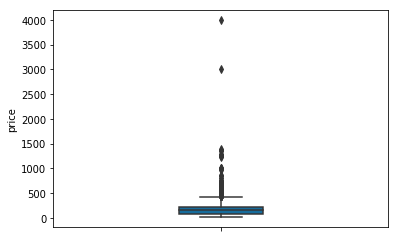

In [48]:
bplot = sns.boxplot(y='price', data=features_set, 
                 width=0.25,
                 palette="colorblind")

#### Lets consider listings with less than 600 price for our analysis as greater than 600$ looks outliers

In [49]:
features_set = features_set[features_set['price']<=600]

In [50]:
features_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3468 entries, 0 to 3584
Data columns (total 61 columns):
host_response_rate                            3019 non-null float64
host_acceptance_rate                          3019 non-null float64
host_is_superhost                             3468 non-null float64
neighbourhood_cleansed                        3468 non-null object
accommodates                                  3468 non-null float64
minimum_nights                                3468 non-null float64
require_guest_profile_picture                 3468 non-null float64
require_guest_phone_verification              3468 non-null float64
price                                         3468 non-null float64
bedrooms                                      3468 non-null float64
bathrooms                                     3468 non-null float64
24-hour_check-in                              3468 non-null float64
air_conditioning                              3468 non-null float64
buzzer/wir

<a id='D'></a>

### Questions/Modeling to understand the dataset

## Flow of Question 

1. What is the best time in a year/week to go to Boston?
2. Which regions would have higher listings concentration?
3. If we consider only the Top regions that has 50% of the listings, how does the price vary on an average? 
4. What are the factors thats driving the price?
        a. Amenities?
        b. Cancellation policy?
        c. response time?

1. What is the best time in a year/week to go to Boston? How does the listings and costing correlate? Are we seeing more listings during the holiday time or is it consistent across the time?

In [51]:
def fun_calendar(col_name):
    
    listings = pd.DataFrame(calendar[calendar['available']=='t'].groupby(col_name)['listing_id'].nunique())
    price_list = pd.DataFrame(calendar[calendar['available']=='t'].groupby(col_name)['price'].mean())
    listings.reset_index(inplace=True)
    price_list.reset_index(inplace=True)
    final_frame = pd.merge(left = listings,right=price_list,left_on=[col_name],right_on=[col_name],suffixes=('_PPL', '_PCT')) 
    fig, ax1 = plt.subplots()

    plt.title('Listings vs. Pricing Trend')

    ax2 = ax1.twinx()
    ax1.plot(final_frame[col_name], final_frame.listing_id, 'g-')
    ax2.plot(final_frame[col_name], final_frame.price, 'b-')


    ax1.set_xlabel(col_name)
    ax1.set_ylabel('Listings', color='g')
    ax2.set_ylabel('Avg. Price/Listing', color='b')

    ax1.set_ylim([0,final_frame.listing_id.max()*1.05])
    ax2.set_ylim([0,300])

    plt.show()   

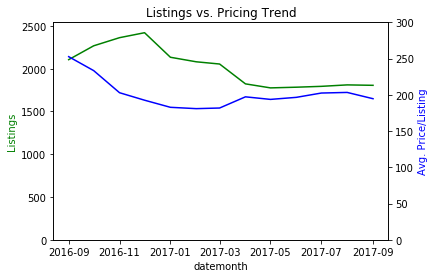

In [52]:
date_check = fun_calendar('datemonth')

> The chart indicates that the offerings/Pricing stagnated over the last 6 months ending Sep' 17. To confirm this, we may need to have longer history of offerings. But we can see a clear hike in the offerings in the 'Christmas holiday period' Average pricing also dropped by nearly "$20"


In [53]:
#Correlation check

calendar.corr(method ='pearson') 

,listing_id,price,dateweekday
listing_id,1.000000e+00,-0.116123,-1.008223e-18
price,-1.161234e-01,1.000000,4.082895e-03
dateweekday,-1.008223e-18,0.004083,1.000000e+00


> As expected we see a negative correlation with price and listings. This confirms our understanding

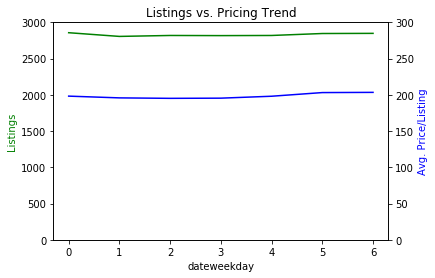

In [54]:
week_check = fun_calendar('dateweekday')

>Price/Listing & Listing are constant around $200 indicating there is no or minimal impact coming from the listings

### 2. Which regions would have higher listings concentration?

In [55]:
features_set.shape

(3468, 61)

In [56]:
features_set = features_set.replace(np.nan, 0)

Text(0.5,1,'# of listings in Boston')

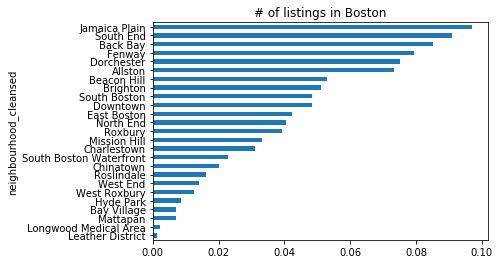

In [57]:
#plt.rcParams['figure.figsize'] = (20,20)
(features_set[['neighbourhood_cleansed','price']].groupby('neighbourhood_cleansed').count()['price']/features_set.shape[0]).sort_values(ascending = True).plot.barh()

plt.title("# of listings in Boston")

In [58]:

listings = (features_set[['neighbourhood_cleansed','price']].groupby('neighbourhood_cleansed').count()['price']/features_set.shape[0]).sort_values(ascending = False)

listings = pd.DataFrame(listings)

listings.reset_index(inplace=True)



In [59]:
listings.iloc[:6,0:].sum()

neighbourhood_cleansed    Jamaica PlainSouth EndBack BayFenwayDorchester...
price                                                              0.500577
dtype: object

In [60]:
Top_5_regions = list(listings.iloc[:6,0])

Top_5_regions

['Jamaica Plain', 'South End', 'Back Bay', 'Fenway', 'Dorchester', 'Allston']

#### Jamaice Plain, South End, Back way, Fenway, Dorchester, Alston represents 50% of the listings. Lets dwell deep into these territories to see whats driving the listings price

In [61]:
features_set=features_set.replace(np.nan, 0)

In [62]:
## Subset the dataset only for those regions that were highlighted earlier

features_model = features_set[features_set['neighbourhood_cleansed'].isin(Top_5_regions)]

features_model.shape

(1736, 61)

#### If we consider the top 6 neighbourhoods, how does the price vary?

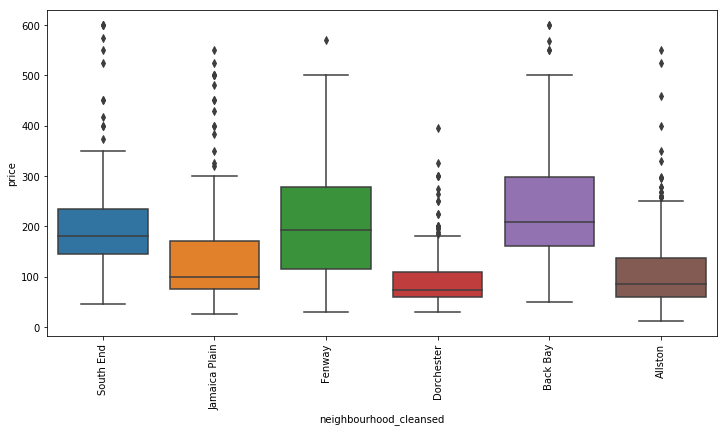

In [63]:
plt.figure(figsize = (12, 6))
sns.boxplot(x = 'neighbourhood_cleansed', y = 'price',  data = features_model.sort_values('neighbourhood_cleansed',ascending = False))
xt = plt.xticks(rotation=90)

#### A clear demarkation in prices can be observed within these Neighbourhoods alone. We can see that South End, Fenway, Back Bay are having higher listing prices. Validating it from the Boston map, we can these regions in the middle of the city and accessible to every facility

#### Summing up everything, a property in South end, Fenway, Back Bay costs twice the property cost in the rest of the neighbourhoods. Let us see what is driving the prices in the regions. Before going further, lets convert the neighbourhood_cleansed column into one-hot encoding for driver analysis

In [64]:
neighbourhood = features_model.neighbourhood_cleansed.str.get_dummies(sep=",")

In [65]:
neighbourhood.head()

,Allston,Back Bay,Dorchester,Fenway,Jamaica Plain,South End
56,0,0,0,0,1,0
57,0,0,0,0,1,0
58,0,0,0,0,1,0
59,0,0,0,0,1,0
60,0,0,0,0,1,0


In [66]:
features_model_vf = pd.concat([features_model,neighbourhood],axis=1)

#### Before implementation of the models, we need to be aware theat since there are various unclean features, the model's ability to predict is always a concern. That means the end model will not be stable. However, the co-efficient can be used to interpret the isolated impact of each and every feature. We will be testing various models that we learnt in our course for this purpose. 

lets check the following - 

    1) All the columns are numeric in nature
    2) There are no NAN values
    3) See if we need to convert them into other transformations

In [67]:
features_model_vf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1736 entries, 56 to 3581
Data columns (total 67 columns):
host_response_rate                            1736 non-null float64
host_acceptance_rate                          1736 non-null float64
host_is_superhost                             1736 non-null float64
neighbourhood_cleansed                        1736 non-null object
accommodates                                  1736 non-null float64
minimum_nights                                1736 non-null float64
require_guest_profile_picture                 1736 non-null float64
require_guest_phone_verification              1736 non-null float64
price                                         1736 non-null float64
bedrooms                                      1736 non-null float64
bathrooms                                     1736 non-null float64
24-hour_check-in                              1736 non-null float64
air_conditioning                              1736 non-null float64
buzzer/wi

In [68]:
## Need to drop neighbour hood column

features_model_vf.drop('neighbourhood_cleansed', inplace = True, axis=1)

In [69]:
features_model_vf.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,accommodates,minimum_nights,require_guest_profile_picture,require_guest_phone_verification,price,bedrooms,bathrooms,24-hour_check-in,air_conditioning,buzzer/wireless_intercom,cable_tv,carbon_monoxide_detector,elevator_in_building,family/kid_friendly,fire_extinguisher,first_aid_kit,free_parking_on_premises,hair_dryer,hot_tub,indoor_fireplace,laptop_friendly_workspace,lock_on_bedroom_door,pets_allowed,pets_live_on_this_property,safety_card,smoke_detector,suitable_for_events,wheelchair_accessible,wireless_internet,translation_missing:_en.hosting_amenity_49,translation_missing:_en.hosting_amenity_50,breakfast,cats,dogs,doorman,dryer,essentials,gym,hangers,heating,internet,iron,kitchen,pool,shampoo,tv,washer,flexible,moderate,strict,super_strict_30,entire_home/apt,not_available,a_few_days_or_more,within_a_day,within_a_few_hours,within_an_hour,Allston,Back Bay,Dorchester,Fenway,Jamaica Plain,South End
56,50.0,100.0,0.0,4.0,3.0,0.0,0.0,140.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0,0,1,0,0,0,0,0,0,1,0
57,100.0,100.0,0.0,2.0,2.0,0.0,0.0,70.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0,0,0,0,1,0,0,0,0,1,0
58,93.0,73.0,0.0,2.0,1.0,0.0,0.0,95.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,1,0
59,0.0,0.0,0.0,2.0,300.0,0.0,0.0,55.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,1,0
60,100.0,89.0,1.0,2.0,2.0,0.0,0.0,80.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,1,0


In [70]:
##Scaling to be applied to make sure that normalization happens

Scalar = SS()

features_vf = pd.DataFrame(Scalar.fit_transform(features_model_vf))

features_vf.columns=features_model_vf.columns

features_vf.index = features_model_vf.index

In [71]:
features_vf.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,accommodates,minimum_nights,require_guest_profile_picture,require_guest_phone_verification,price,bedrooms,bathrooms,24-hour_check-in,air_conditioning,buzzer/wireless_intercom,cable_tv,carbon_monoxide_detector,elevator_in_building,family/kid_friendly,fire_extinguisher,first_aid_kit,free_parking_on_premises,hair_dryer,hot_tub,indoor_fireplace,laptop_friendly_workspace,lock_on_bedroom_door,pets_allowed,pets_live_on_this_property,safety_card,smoke_detector,suitable_for_events,wheelchair_accessible,wireless_internet,translation_missing:_en.hosting_amenity_49,translation_missing:_en.hosting_amenity_50,breakfast,cats,dogs,doorman,dryer,essentials,gym,hangers,heating,internet,iron,kitchen,pool,shampoo,tv,washer,flexible,moderate,strict,super_strict_30,entire_home/apt,not_available,a_few_days_or_more,within_a_day,within_a_few_hours,within_an_hour,Allston,Back Bay,Dorchester,Fenway,Jamaica Plain,South End
56,-0.924469,0.777829,-0.368952,0.644543,-0.033732,-0.139203,-0.283326,-0.230090,-0.279024,-0.4436,-0.690066,0.557834,-0.557834,1.001153,-1.433994,-0.547176,0.969363,-0.888645,-0.635134,1.786963,-1.020957,-0.222658,-0.377964,-1.077911,-0.406326,-0.390797,-0.373973,-0.382925,-2.056433,-0.19245,-0.187568,-4.878524,-0.396653,-0.471736,-0.327327,-0.233833,-0.276144,-0.240607,0.647658,-2.144761,-0.339064,-1.125308,0.233833,0.613747,-1.001153,0.289215,-0.16313,-1.390120,0.648554,0.642285,-0.598642,1.646026,-0.881401,-0.173974,0.829889,-0.389817,-0.123307,2.638807,-0.767948,-0.744421,-0.413993,-0.452459,-0.420653,-0.433852,2.041241,-0.470824
57,0.533769,0.777829,-0.368952,-0.573668,-0.125086,-0.139203,-0.283326,-0.924967,-0.279024,-0.4436,-0.690066,0.557834,-0.557834,1.001153,0.697353,-0.547176,0.969363,1.125308,-0.635134,-0.559609,-1.020957,-0.222658,-0.377964,-1.077911,-0.406326,-0.390797,2.673992,-0.382925,0.486279,-0.19245,-0.187568,0.204980,-0.396653,-0.471736,-0.327327,-0.233833,3.621301,-0.240607,0.647658,-2.144761,-0.339064,-1.125308,0.233833,0.613747,-1.001153,0.289215,-0.16313,-1.390120,0.648554,0.642285,-0.598642,-0.607524,1.134557,-0.173974,-1.204980,-0.389817,-0.123307,-0.378959,-0.767948,1.343326,-0.413993,-0.452459,-0.420653,-0.433852,2.041241,-0.470824
58,0.329615,0.009702,-0.368952,-0.573668,-0.216441,-0.139203,-0.283326,-0.676797,-0.279024,-0.4436,1.449138,0.557834,-0.557834,1.001153,-1.433994,-0.547176,-1.031605,-0.888645,-0.635134,1.786963,0.979473,-0.222658,-0.377964,0.927720,-0.406326,-0.390797,-0.373973,-0.382925,-2.056433,-0.19245,-0.187568,0.204980,-0.396653,-0.471736,-0.327327,-0.233833,-0.276144,-0.240607,0.647658,0.466252,-0.339064,0.888645,0.233833,-1.629336,0.998849,0.289215,-0.16313,0.719363,0.648554,0.642285,1.670447,-0.607524,-0.881401,-0.173974,-1.204980,-0.389817,-0.123307,2.638807,-0.767948,-0.744421,-0.413993,-0.452459,-0.420653,-0.433852,2.041241,-0.470824
59,-2.382706,-2.067086,-0.368952,-0.573668,27.098579,-0.139203,-0.283326,-1.073870,-0.279024,-0.4436,-0.690066,-1.792650,1.792650,1.001153,-1.433994,-0.547176,-1.031605,-0.888645,-0.635134,-0.559609,-1.020957,-0.222658,2.645751,-1.077911,-0.406326,-0.390797,-0.373973,-0.382925,-2.056433,-0.19245,-0.187568,0.204980,-0.396653,-0.471736,3.055050,-0.233833,-0.276144,-0.240607,0.647658,-2.144761,-0.339064,-1.125308,0.233833,0.613747,-1.001153,0.289215,-0.16313,-1.390120,0.648554,0.642285,1.670447,-0.607524,-0.881401,-0.173974,-1.204980,2.565304,-0.123307,-0.378959,-0.767948,-0.744421,-0.413993,-0.452459,-0.420653,-0.433852,2.041241,-0.470824
60,0.533769,0.464888,2.710379,-0.573668,-0.125086,-0.139203,-0.283326,-0.825699,-0.279024,-0.4436,-0.690066,0.557834,-0.557834,-0.998849,0.697353,-0.547176,-1.031605,1.125308,1.574471,1.786963,0.979473,-0.222658,-0.377964,-1.077911,-0.406326,-0.390797,-0.373973,2.611478,0.486279,-0.19245,-0.187568,0.204980,-0.396653,-0.471736,3.055050,-0.233833,-0.276144,-0.240607,0.647658,0.466252,-0.339064,0.888645,0.233833,0.613747,0.998849,0.289215,-0.16313,0.719363,0.648554,

### Evaluating Models - We will try fitting the Linear regression, Ridge Regression, SVM on a training dataset with different sample rate. Based on the model that gives best fit, we will implement it further

In [74]:
# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_vf.drop('price', axis='columns'), 
                                                    features_vf['price'], 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

clf_base = LinearRegression()
clf_ridge = linear_model.Ridge(alpha=.5)
clf_svm = svm.SVR(kernel='linear', C=100, gamma='auto')


Training set has 1388 samples.
Testing set has 348 samples.


In [75]:
def prediction_fact(clf, sample_size, X_train, y_train, X_test, y_test):
    """
    Write a function that call
    1) CLF 
    2) Trains the model
    3) Predicts the Y value
    4) Compares to test if it is under fitting or over fitting
    """
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = clf.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end-start
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = clf.predict(X_test)
    predictions_train = clf.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end-start

    results['test_mse'] = mean_squared_error(y_test, predictions_test)
    results['test_rmse'] = results['test_mse'] **(1/2)
    results['test_r2_score'] = r2_score(y_test, predictions_test)
    
    
    results['train_mse'] = mean_squared_error(y_train[:300], predictions_train)
    results['train_rmse'] = results['train_mse']**(1/2)
    results['train_r2_score'] = r2_score(y_train[:300], predictions_train)
    
    return results  

In [76]:
samples_100 = int(round(len(X_train)))
samples_10 = int(round(len(X_train) / 10))
samples_1 = int(round(len(X_train) / 100))

# Collect results on the learners
results = {}
for clf in [ clf_base, clf_ridge, clf_svm, clf_rbf]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        prediction_fact(clf, samples, X_train, y_train, X_test, y_test)

In [77]:
results

{'LinearRegression': {0: {'pred_time': 0.0,
   'test_mse': 0.52406269724829502,
   'test_r2_score': 0.36817162966604133,
   'test_rmse': 0.72392174801444875,
   'train_mse': 0.65140497027648869,
   'train_r2_score': 0.33048218598945489,
   'train_rmse': 0.80709663007380272,
   'train_time': 0.0},
  1: {'pred_time': 0.0,
   'test_mse': 0.42975488233204462,
   'test_r2_score': 0.48187243936145019,
   'test_rmse': 0.65555692531773668,
   'train_mse': 0.3067088169158414,
   'train_r2_score': 0.68476289557309467,
   'train_rmse': 0.55381298008970625,
   'train_time': 0.015588998794555664},
  2: {'pred_time': 0.0,
   'test_mse': 0.26001615686043172,
   'test_r2_score': 0.68651540071017703,
   'test_rmse': 0.50991779421827566,
   'train_mse': 0.24706032974601408,
   'train_r2_score': 0.74606995732613612,
   'train_rmse': 0.49705163690105081,
   'train_time': 0.0}},
 'Ridge': {0: {'pred_time': 0.0,
   'test_mse': 0.52168308718429723,
   'test_r2_score': 0.37104057102870747,
   'test_rmse': 0.7

In [81]:
list_mod = ['LinearRegression','Ridge','SVR']

list_params = ['mse','r2_score','rmse']
#figure, axs = plt.subplots(nrows=len(list_mod), figsize = (20,20))
#figure.subplots_adjust(hspace = 1, wspace=.3)

def plotter(var_train, var_test):
    """
    Write a plotter function that will take the metric as input and compare that metric across test & training over the differe
    sampling rates for different models
    0 - 1% Sample
    1 - 10% Sample
    2 - 100% Sample
    """
    for type_mod in list_mod:        
        list_test=[]
        list_train=[]
        length_bar = []

        for i in range(3):
            list_train.append(results[type_mod][i][var_train])
            list_test.append(results[type_mod][i][var_test])

        length_bar = np.arange(len(list_train))
        width = 0.35

        fig, ax = plt.subplots()
        rects1 = ax.bar(length_bar - width/2, list_train, width, label='Train')
        rects2 = ax.bar(length_bar + width/2, list_test, width, label='Test')

        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel('Scores')
        ax.set_title('{} vs. {} & {}'.format(type_mod,var_train, var_test))
        ax.set_xticks(length_bar)
        #ax.set_xticklabels(labels)
        ax.legend()

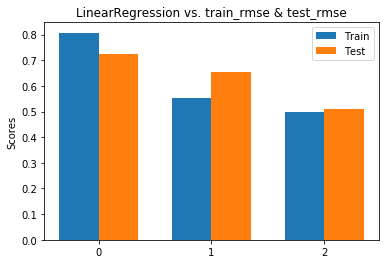

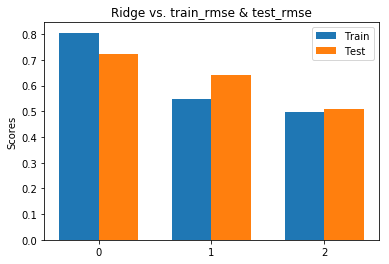

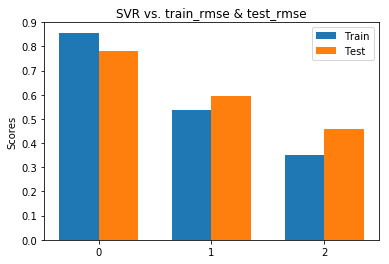

In [80]:
## Check RMSE of the models as starting point

results_rmse = plotter('train_rmse','test_rmse')

RMSE across three models -

1. As evident, by the sample size increase the RMSE decreases
2. Linear regression has the higher RMSE, followed by Ridge & SVM
3. Ridge & SVM models are clear winners here as we see minimal RMSE across all the scenarios
4. However, SVM Models are forcefitting for Training dataset - Lets evaluate the R Sqare metric to further look into this

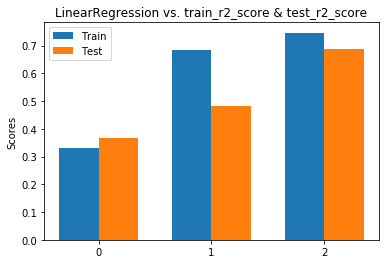

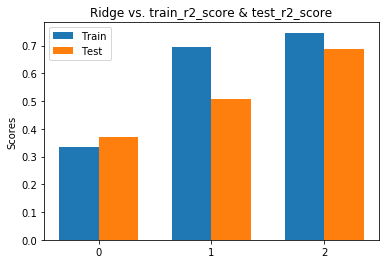

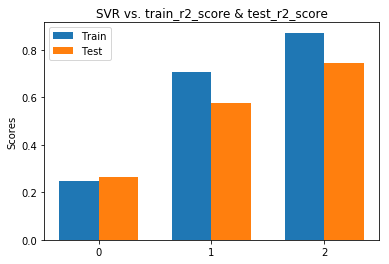

In [82]:
plotter('train_r2_score','test_r2_score')

R-Square is highest for the SVM. However there are over-fitting problems. Considering the weightage between Pros & Cons, I will consider the SVM for now

In [83]:
print('Current SVM parameters are :\n')
pprint(clf_svm.get_params())

Current SVM parameters are :

{'C': 100,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'auto',
 'kernel': 'linear',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}


#### Hyperparameter tuning for SVM with linear Kernel

In [84]:
Cs = [0.001, 0.01, 0.1, 1, 10]
param_grid = {'C': Cs}
grid_search = GridSearchCV(svm.SVR(kernel='linear'), param_grid, cv=5)
grid_fit = grid_search.fit(X_train, y_train)

In [85]:
best_clf = grid_fit.best_estimator_
pprint(best_clf.get_params())

{'C': 0.1,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'auto',
 'kernel': 'linear',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}


In [86]:
# Make predictions using the unoptimized and model
predictions = (clf_rbf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

In [88]:
print("\nOptimized Model\n------")
print("R-Square on the testing data: {:.4f}".format(r2_score(y_test, best_predictions)))
print("MSE on the testing data: {:.4f}".format(mean_squared_error(y_test, best_predictions)))



Optimized Model
------
R-Square on the testing data: 0.7110
MSE on the testing data: 0.2397


<a id='E'></a>

### Evaluation of the model co-efficient and try to find the isolated impact of various attributes

In [89]:
coefs = list(zip(best_clf.coef_, X_train.columns))
coefs

[(array([ 0.00312426, -0.06905913,  0.01167035,  0.15532106, -0.01594798,
         -0.03994119,  0.05110903,  0.29319064,  0.03118123, -0.03233618,
          0.03754988,  0.00988303,  0.02745095,  0.04060182,  0.00245245,
         -0.015301  , -0.00066017, -0.00221417, -0.00745758,  0.04261772,
         -0.02373899,  0.05734443,  0.02791116, -0.02285905,  0.02158864,
          0.01337861, -0.01270706, -0.02381221, -0.00951866,  0.00917572,
         -0.00285382, -0.01906305,  0.02929687,  0.00278446, -0.02576759,
         -0.00696421,  0.04134772,  0.01103797,  0.00867706,  0.0474255 ,
         -0.04096799,  0.01480275, -0.03146586,  0.00598535, -0.02530907,
         -0.04028911,  0.00274457,  0.04586862,  0.00596498, -0.01818916,
          0.00150685, -0.01621958,  0.09115657,  0.23807048, -0.06102874,
          0.01587436, -0.01915632,  0.03175787,  0.02031485, -0.08338243,
          0.15795698, -0.12718799,  0.04694048, -0.0926777 ,  0.09102138]),
  'host_response_rate')]

In [90]:
model_coeff = pd.DataFrame(best_clf.coef_).T

coeffecient_matrix = pd.merge(model_coeff, pd.DataFrame(X_train.columns), left_index=True, right_index=True)

coeffecient_matrix.columns = ['Value','Variable']

coeffecient_matrix

,Value,Variable
0,0.003124,host_response_rate
1,-0.069059,host_acceptance_rate
2,0.011670,host_is_superhost
3,0.155321,accommodates
4,-0.015948,minimum_nights
5,-0.039941,require_guest_profile_picture
6,0.051109,require_guest_phone_verification
7,0.293191,bedrooms
8,0.031181,bathrooms
9,-0.032336,24-hour_check-in


In [91]:
coeffecient_matrix.set_index('Variable')

,Value
Variable,
host_response_rate,0.003124
host_acceptance_rate,-0.069059
host_is_superhost,0.011670
accommodates,0.155321
minimum_nights,-0.015948
require_guest_profile_picture,-0.039941
require_guest_phone_verification,0.051109
bedrooms,0.293191
bathrooms,0.031181


#### Evaluating all the variables

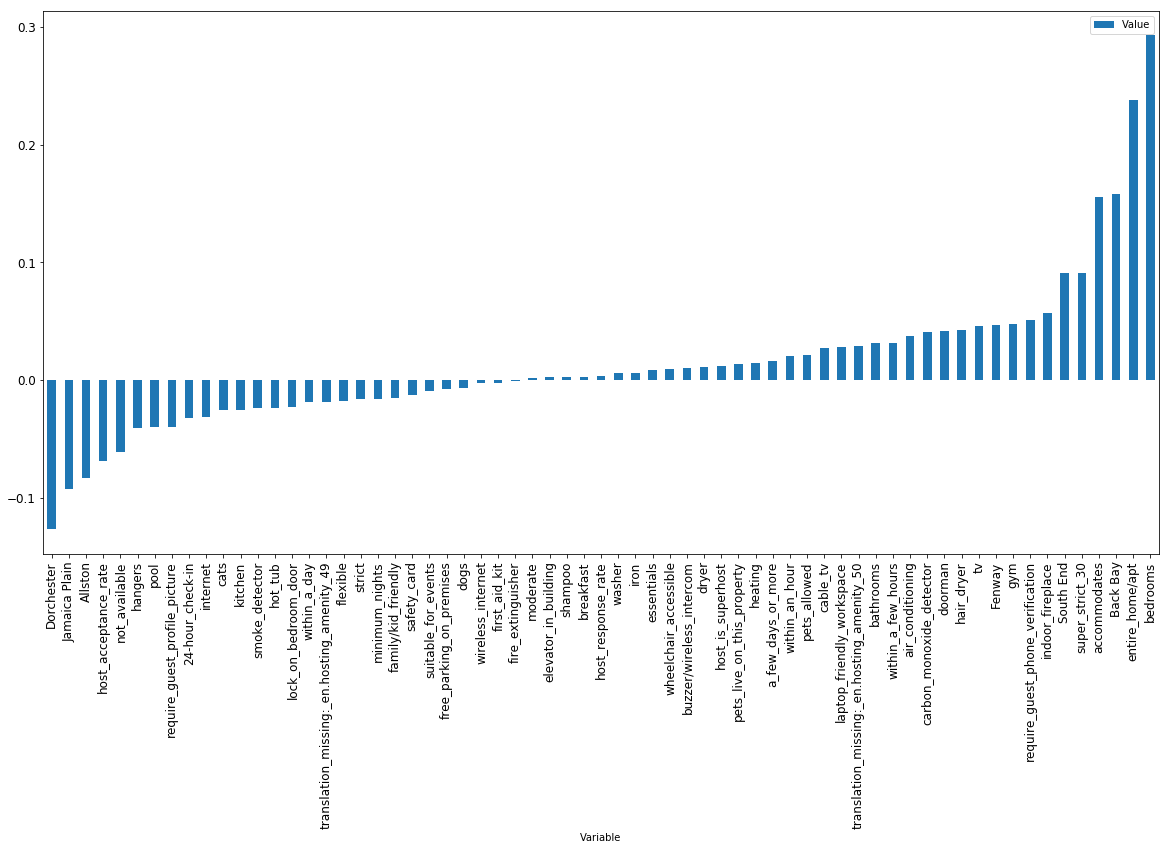

In [98]:
coeffecient_matrix.set_index('Variable').sort_values('Value').plot.bar(rot=90,figsize=(20,10), fontsize=12)

Here are the quick comments from the variable co-efficients (Please note, the P-Value check may result in few variable being insignificant - Consider these results directional only)

1. No. of Bedrooms, Accomodation & Home/ Apartments listings are the ones that attract maximum price. This is intutive given the Sq.Ft information is not clean, we should ideally normalize price / sq.ft
2. Super Struct 30 is a definite driver of pricing of the listing (Though the coverage is less here) Probably they are the most loyal base of customers for AirBnb
3. Properties in Back Bay, South End, Femway drive the overall Pricing cost (As we observed in our earlier analysis)
4. AMenities - Indoor fireplace, Gym, TV, Hairdryer, Doorman are definite indicators for higher price listing; parking facilities not available, hangers, pools amenities drive listing price less


<a id='F'></a>

#### To sum-up everything and to Conclude

> What is the best time to visting Boston and thrive on AirBnb? 
a. December to February can be considered as the ideal time period. While the Weekend price listings are 10 to 20 units cheaper, there is no real correlation between the listings and day of the week

> Which areas see higher listings concentration? Jamaice Plain, South End, Back way, Fenway, Dorchester, Alston represents 50% of the listings. Lets dwell deep into these territories to see whats driving the listings price


> If we consider only the regions that contribute to 50% of the listings, how does the pricing vary? A clear demarkation in prices can be observed within these Neighbourhoods alone. We can see that South End, Fenway, Back Bay are having higher listing prices. Validating it from the Boston map, we can these regions in the middle of the city and accessible to every facility. Summing up everything, a property in South end, Fenway, Back Bay costs twice the property cost in the rest of the neighbourhoods. Let us see what is driving the prices in the regions. Before going further, lets convert the neighbourhood_cleansed column into one-hot encoding for driver analysis

> Driver analysis indicates that -
1. No. of Bedrooms, Accomodation & Home/ Apartments listings are the ones that attract maximum price. This is intutive given the Sq.Ft information is not clean, we should ideally normalize price / sq.ft
2. Super Struct 30 is a definite driver of pricing of the listing (Though the coverage is less here) Probably they are the most loyal base of customers for AirBnb
3. Properties in Back Bay, South End, Femway drive the overall Pricing cost (As we observed in our earlier analysis)
4. AMenities - Indoor fireplace, Gym, TV, Hairdryer, Doorman are definite indicators for higher price listing; parking facilities not available, hangers, pools amenities drive listing price less